In [38]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

In [40]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [41]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'
VERSION ='v7t/'
YVERSION ='v7ty/'

In [42]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [43]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

page_index                                               Page  \
0           0            2NE1_zh.wikipedia.org_all-access_spider   
1           1             2PM_zh.wikipedia.org_all-access_spider   
2           2              3C_zh.wikipedia.org_all-access_spider   
3           3         4minute_zh.wikipedia.org_all-access_spider   
4           4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   

   median_pred_60  median_pred_120  prevYear_median_pred_60  \
0              24               23                       16   
1              24               22                       14   
2               3                3                        4   
3              15               19                       14   
4              14               14                        3   

   prevYear_median_pred_120  smape_60_to_0  smape_120_to_60  \
0                        17      32.278432        25.959053   
1                        17      42.847863        34.415304   
2                         6      64.305367        65.870407   
3                        14      32.250349        33.896551   
4                         5      48.547274        38.718059   

   prevYear_smape_60_to_0  prevYear_smape_120_to_60  nans_start_to_120  \
0               40.870388                 32.116348                  0   
1               60.431899                 32.054860                  0   
2               47.163640                 56.748585                  0   
3               35.401843                 49.278494                  0   
4               54.426324                 57.220372                291   

   nans_120_to_60  nans_60_to_0  prevYear_nans_60_to_0  \
0               0             0                      0   
1               0             0                      0   
2               0             0                      0   
3               0             0                      0   
4               0             0                      0   

   prevYear_nans_120_to_60  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

In [44]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


page_index  v7t_train     v7t_val
0           0  46.736751   32.642601
1           1  48.666767   83.565553
2           2  69.758611  120.451293
3           3  45.255355   38.493515
4           4  66.002965   89.498846

In [45]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

64.5948646161
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7ty_train    145059 non-null float64
v7ty_val      141348 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
84.8706792497


page_index  v7ty_train    v7ty_val
0           0   47.323987   44.956479
1           1   48.262866   61.287282
2           2   71.127792   58.073251
3           3   46.191346   52.285567
4           4   62.962499  132.877882

In [46]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 5)
(145063, 19)


page_index  v7ty_train    v7ty_val  v7t_train     v7t_val  \
0           0   47.323987   44.956479  46.736751   32.642601   
1           1   48.262866   61.287282  48.666767   83.565553   
2           2   71.127792   58.073251  69.758611  120.451293   
3           3   46.191346   52.285567  45.255355   38.493515   
4           4   62.962499  132.877882  66.002965   89.498846   

                                                Page  median_pred_60  \
0            2NE1_zh.wikipedia.org_all-access_spider              24   
1             2PM_zh.wikipedia.org_all-access_spider              24   
2              3C_zh.wikipedia.org_all-access_spider               3   
3         4minute_zh.wikipedia.org_all-access_spider              15   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...              14   

   median_pred_120  prevYear_median_pred_60  prevYear_median_pred_120  \
0               23                       16                        17   
1               22                       14                        17   
2                3                        4                         6   
3               19                       14                        14   
4               14                        3                         5   

     ...      smape_120_to_60  prevYear_smape_60_to_0  \
0    ...            25.959053               40.870388   
1    ...            34.415304               60.431899   
2    ...            65.870407               47.163640   
3    ...            33.896551               35.401843   
4    ...            38.718059               54.426324   

   prevYear_smape_120_to_60  nans_start_to_120  nans_120_to_60  nans_60_to_0  \
0                 32.116348                  0               0             0   
1                 32.054860                  0               0             0   
2                 56.748585                  0               0             0   
3                 49.278494                  0               0             0   
4                 57.220372                291               0             0   

   prevYear_nans_60_to_0  prevYear_nans_120_to_60  Ytest_gain  test_gain  
0                      0                        0  -12.678048  -0.364169  
1                      0                        0  -18.439419 -40.717689  
2                      0                        0    6.232116 -56.145926  
3                      0                        0  -20.035218  -6.243166  
4                      0                        0  -84.330608 -40.951572  

[5 rows x 21 columns]

In [121]:
median_rolling_smape =  wiki.val.load_test_median_rolling_smape()

median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


100%|██████████| 792/792 [06:09<00:00,  2.14it/s]


TEST VERSION so can"t see data train.iloc[:,-60:]
median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


In [122]:
print(median_rolling_smape.iloc[[0],[0,-1]])
print(median_rolling_smape.shape)
median_rolling_smape.head()

   2015-07-01  2017-08-31
0         NaN         NaN
(145063, 793)


2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0         NaN   59.292576   47.521198   42.279365   43.644768   45.184539   
1         NaN   73.260387   69.616005   67.684029   68.770630   69.095268   
2         NaN   99.293651  180.000000   99.626984  101.293651  100.341270   
3         NaN   88.967936   70.416485   56.959173   69.960825   55.197029   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10     ...      2017-08-22  \
0   43.202023   41.268254   42.592001   44.607579     ...             NaN   
1   70.576750   71.639287   71.655954   74.052468     ...             NaN   
2  100.722222   99.388889   99.388889   99.055556     ...             NaN   
3   60.669316   53.567910   52.966730   54.192555     ...             NaN   
4         NaN         NaN         NaN         NaN     ...             NaN   

   2017-08-23  2017-08-24  2017-08-25  2017-08-26  2017-08-27  2017-08-28  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2017-08-29  2017-08-30  2017-08-31  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 793 columns]

In [123]:
yhat_rolling_smape =  wiki.val.load_prophet_rolling_smape(VERSION, test_version=True)

prophet_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum() -> 145063


In [124]:
print(yhat_rolling_smape.iloc[[0],[0,-1]])
print(yhat_rolling_smape.shape)
yhat_rolling_smape.head()

   2015-08-30  2017-08-31
0      46.014         NaN
(145063, 733)


2015-08-30  2015-08-31  2015-09-01  2015-09-02  2015-09-03  2015-09-04  \
0    46.01400    45.40289    45.30144    44.52684    45.14765    45.53654   
1    53.50449    53.26103    53.13358    52.39626    52.15095    51.44100   
2    71.58922    71.25588    72.57456    72.46874    72.02430    72.02430   
3    53.84082    54.01158    53.71279    52.48091    52.18176    52.27033   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-09-05  2015-09-06  2015-09-07  2015-09-08     ...      2017-08-22  \
0    46.25179    46.21211    46.71445    45.58791     ...             NaN   
1    50.79423    51.01956    52.92075    53.88034     ...             NaN   
2    71.74652    72.80472    72.63806    72.16187     ...             NaN   
3    52.99497    52.96078    53.43351    53.60186     ...             NaN   
4         NaN         NaN         NaN         NaN     ...             NaN   

   2017-08-23  2017-08-24  2017-08-25  2017-08-26  2017-08-27  2017-08-28  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2017-08-29  2017-08-30  2017-08-31  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 733 columns]

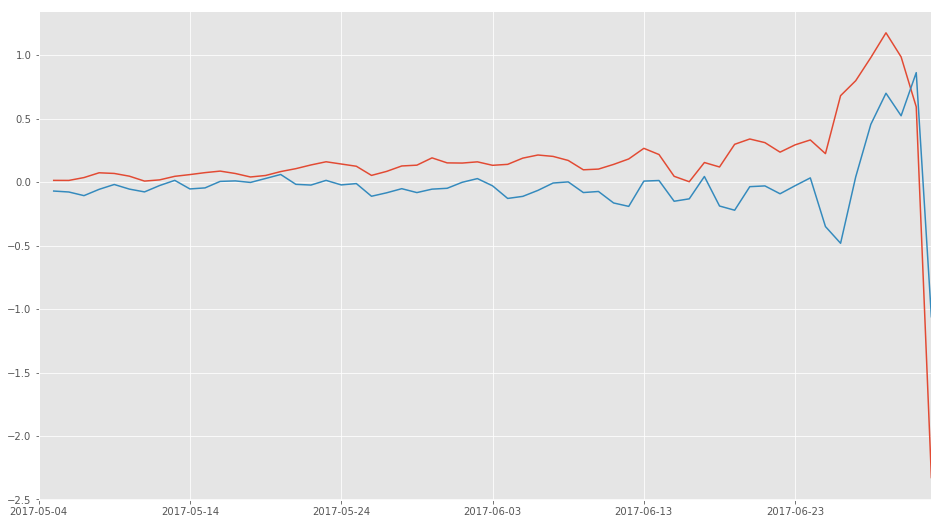

In [130]:
yhat_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()

In [131]:
# remove the yhat smape for the t
yhat_rolling_smape2 = yhat_rolling_smape.copy()
#yhat_rolling_smape2.iloc[:,-120:] = np.nan

In [190]:
cut_off = None
df['rolling_gain_mean'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape2.iloc[:,:cut_off]).mean(axis=1)
df['rolling_gain_std'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape2.iloc[:,:cut_off]).std(axis=1)

In [191]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

200.0 -193.587283558
172.734306215 0.0


In [192]:
df.head()

page_index  v7ty_train    v7ty_val  v7t_train     v7t_val  \
0           0   47.323987   44.956479  46.736751   32.642601   
1           1   48.262866   61.287282  48.666767   83.565553   
2           2   71.127792   58.073251  69.758611  120.451293   
3           3   46.191346   52.285567  45.255355   38.493515   
4           4   62.962499  132.877882  66.002965   89.498846   

                                                Page  median_pred_60  \
0            2NE1_zh.wikipedia.org_all-access_spider              24   
1             2PM_zh.wikipedia.org_all-access_spider              24   
2              3C_zh.wikipedia.org_all-access_spider               3   
3         4minute_zh.wikipedia.org_all-access_spider              15   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...              14   

   median_pred_120  prevYear_median_pred_60  prevYear_median_pred_120  \
0               23                       16                        17   
1               22                       14                        17   
2                3                        4                         6   
3               19                       14                        14   
4               14                        3                         5   

         ...         prevYear_smape_120_to_60  nans_start_to_120  \
0        ...                        32.116348                  0   
1        ...                        32.054860                  0   
2        ...                        56.748585                  0   
3        ...                        49.278494                  0   
4        ...                        57.220372                291   

   nans_120_to_60  nans_60_to_0  prevYear_nans_60_to_0  \
0               0             0                      0   
1               0             0                      0   
2               0             0                      0   
3               0             0                      0   
4               0             0                      0   

   prevYear_nans_120_to_60  Ytest_gain  test_gain  rolling_gain_mean  \
0                        0  -12.678048  -0.364169          -4.586877   
1                        0  -18.439419 -40.717689          -5.471587   
2                        0    6.232116 -56.145926         -11.048583   
3                        0  -20.035218  -6.243166          -2.399449   
4                        0  -84.330608 -40.951572          11.684981   

   rolling_gain_std  
0          7.105016  
1          6.573979  
2         13.843225  
3          6.971026  
4         33.645347  

[5 rows x 23 columns]

In [193]:
df[['rolling_gain_mean','test_gain','rolling_gain_std']].corr()

rolling_gain_mean  test_gain  rolling_gain_std
rolling_gain_mean           1.000000   0.568253         -0.321331
test_gain                   0.568253   1.000000         -0.565914
rolling_gain_std           -0.321331  -0.565914          1.000000

# Feature Testing Area

In [ ]:
yhat = wiki.newphet.load_prophet_prop(VERSION, 'yhat')
trend = wiki.newphet.load_prophet_prop(VERSION, 'trend')

 29%|██▉       | 42114/145063 [02:08<05:45, 297.59it/s]

# Filter Testing

In [194]:
#BASE_SCORE = df.smape_60_to_0.mean(); BASE_SCORE

In [195]:
BASE_SCORE

41.043204039840212

In [196]:
filter_df = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0)
             )

In [197]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

40.834855883471157

In [170]:
filter_df = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0) &
             
             )

In [171]:
pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).mean()

43.11003371518094

In [172]:
filter_df3 = ((df['rolling_gain_std'] < 12) &
            (df['Ytest_gain'] > 0)
             )

In [173]:
pd.concat([df[filter_df3].v7t_val,
           df[~filter_df3].smape_60_to_0]).mean()

41.514588832638829

# Plotting best and worst

page_index                                                               6682
v7ty_train                                                            17.1723
v7ty_val                                                              23.6652
v7t_train                                                             17.2991
v7t_val                                                               192.165
Page                        Loi_1_du_football_fr.wikipedia.org_desktop_all...
median_pred_60                                                            198
median_pred_120                                                           248
prevYear_median_pred_60                                                   484
prevYear_median_pred_120                                                  377
smape_60_to_0                                                         31.4078
smape_120_to_60                                                        31.808
prevYear_smape_60_to_0                                          

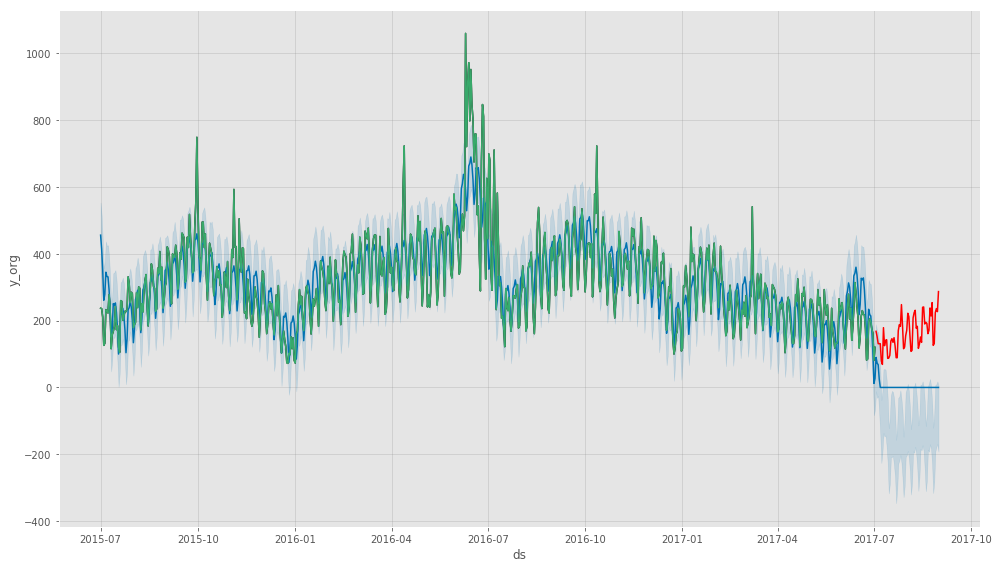

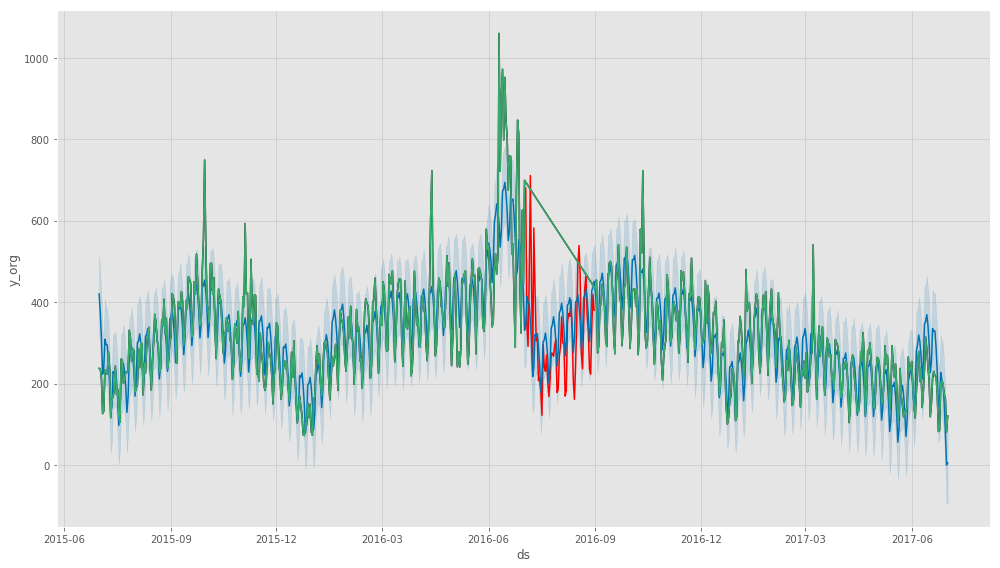

page_index                                                      9058
v7ty_train                                                   10.9641
v7ty_val                                                      17.928
v7t_train                                                    10.8709
v7t_val                                                      149.831
Page                        Euro_en.wikipedia.org_desktop_all-agents
median_pred_60                                                  2381
median_pred_120                                                 2576
prevYear_median_pred_60                                         3313
prevYear_median_pred_120                                        2897
smape_60_to_0                                                18.2572
smape_120_to_60                                              19.7491
prevYear_smape_60_to_0                                       46.7325
prevYear_smape_120_to_60                                     28.0001
nans_start_to_120                 

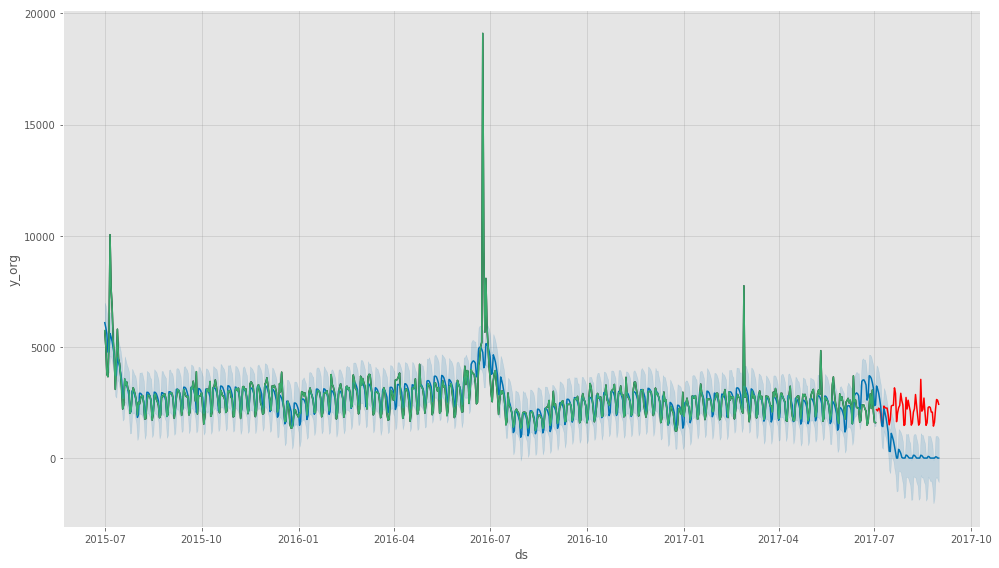

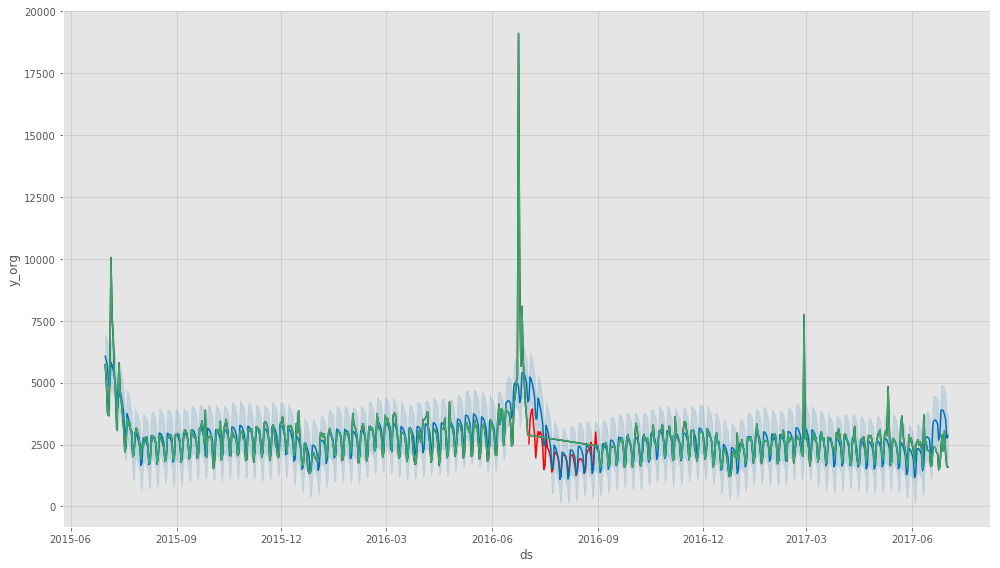

page_index                                                         126652
v7ty_train                                                        31.3963
v7ty_val                                                           40.917
v7t_train                                                         32.6124
v7t_val                                                           184.047
Page                        Мехмед_III_ru.wikipedia.org_all-access_spider
median_pred_60                                                         11
median_pred_120                                                        16
prevYear_median_pred_60                                                25
prevYear_median_pred_120                                               29
smape_60_to_0                                                     54.8168
smape_120_to_60                                                   48.4185
prevYear_smape_60_to_0                                             57.008
prevYear_smape_120_to_60              

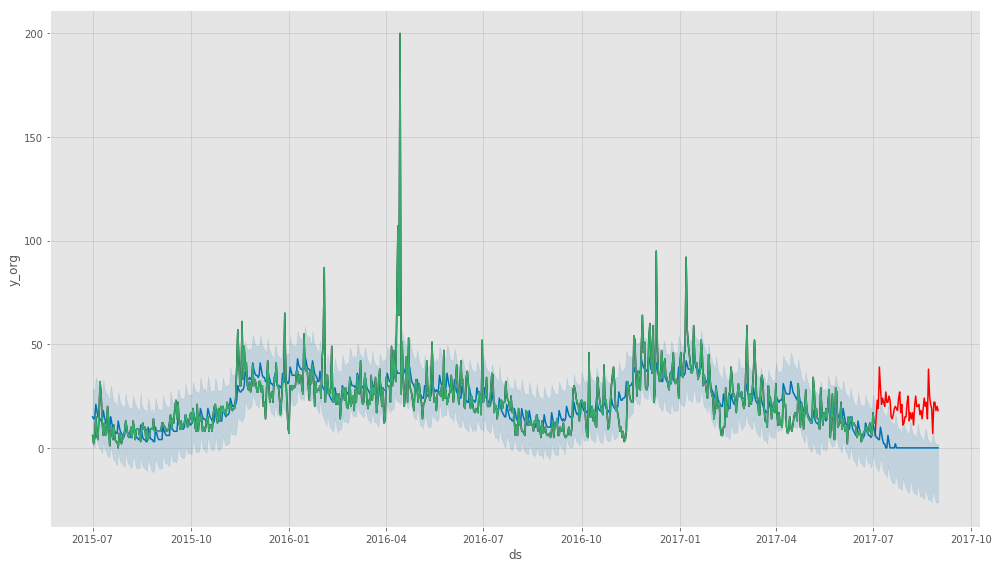

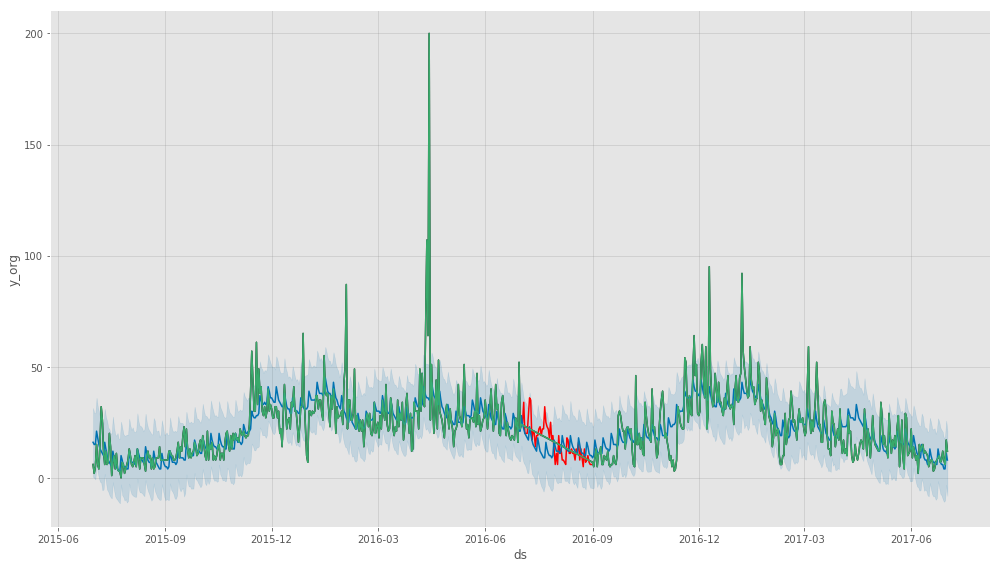

page_index                                                              71731
v7ty_train                                                             20.687
v7ty_val                                                              30.0506
v7t_train                                                             19.8791
v7t_val                                                               162.826
Page                        Unión_Europea_es.wikipedia.org_desktop_all-agents
median_pred_60                                                           2052
median_pred_120                                                          2218
prevYear_median_pred_60                                                  2979
prevYear_median_pred_120                                                 2415
smape_60_to_0                                                         43.1525
smape_120_to_60                                                       27.5711
prevYear_smape_60_to_0                                          

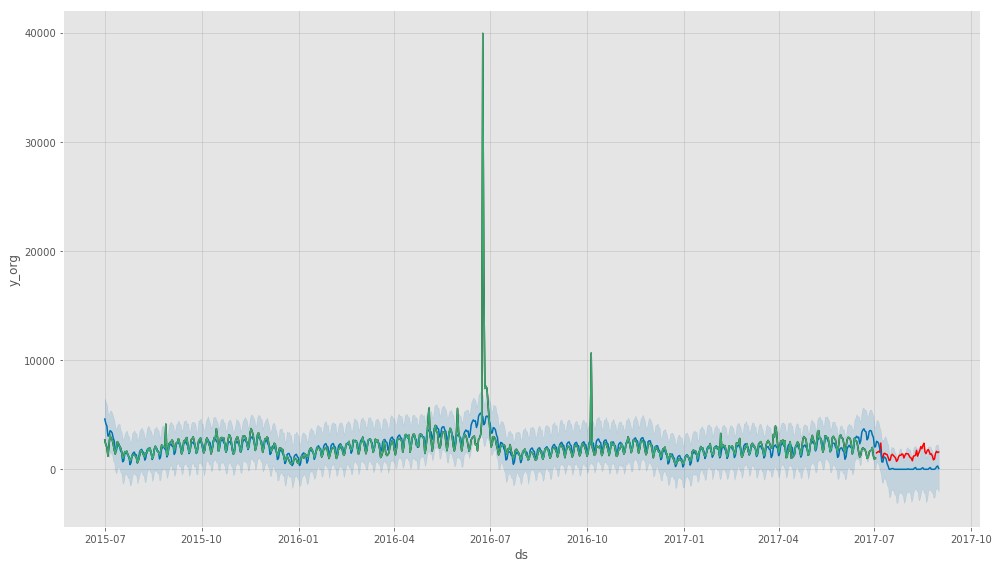

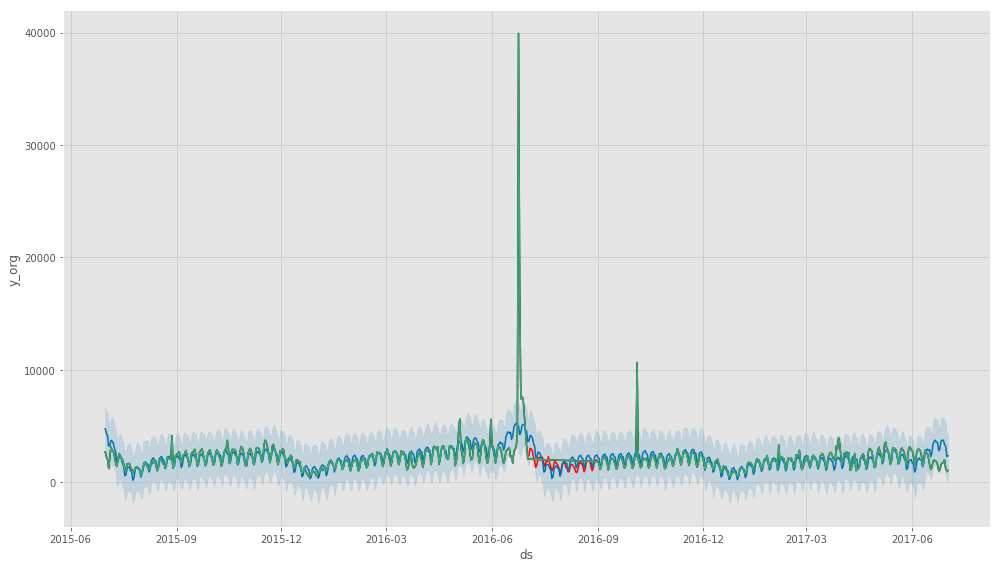

page_index                                                               7693
v7ty_train                                                            21.2324
v7ty_val                                                              30.7527
v7t_train                                                              21.041
v7t_val                                                               173.852
Page                        États_membres_de_l'Union_européenne_fr.wikiped...
median_pred_60                                                            527
median_pred_120                                                           524
prevYear_median_pred_60                                                   910
prevYear_median_pred_120                                                  837
smape_60_to_0                                                         56.3276
smape_120_to_60                                                       30.9641
prevYear_smape_60_to_0                                          

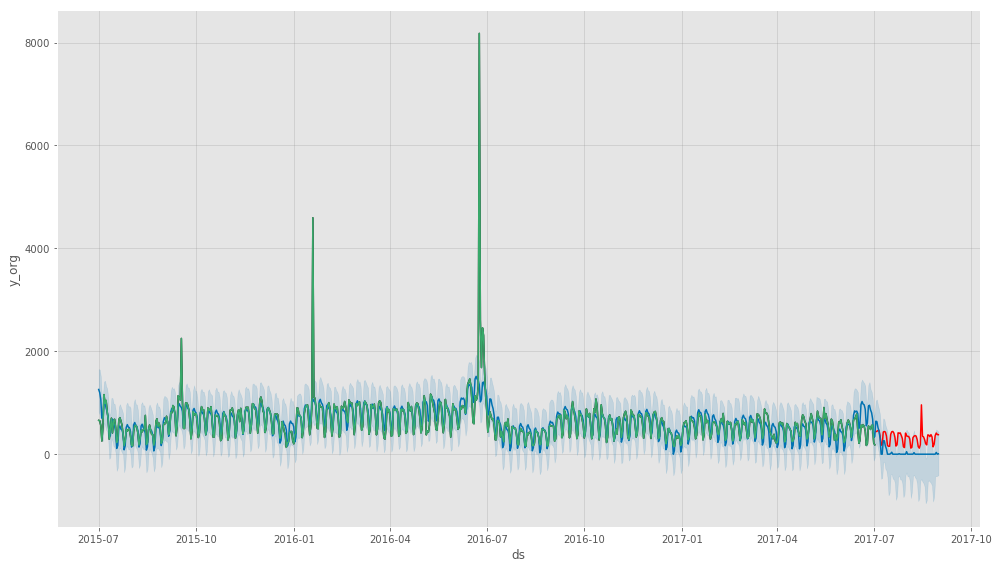

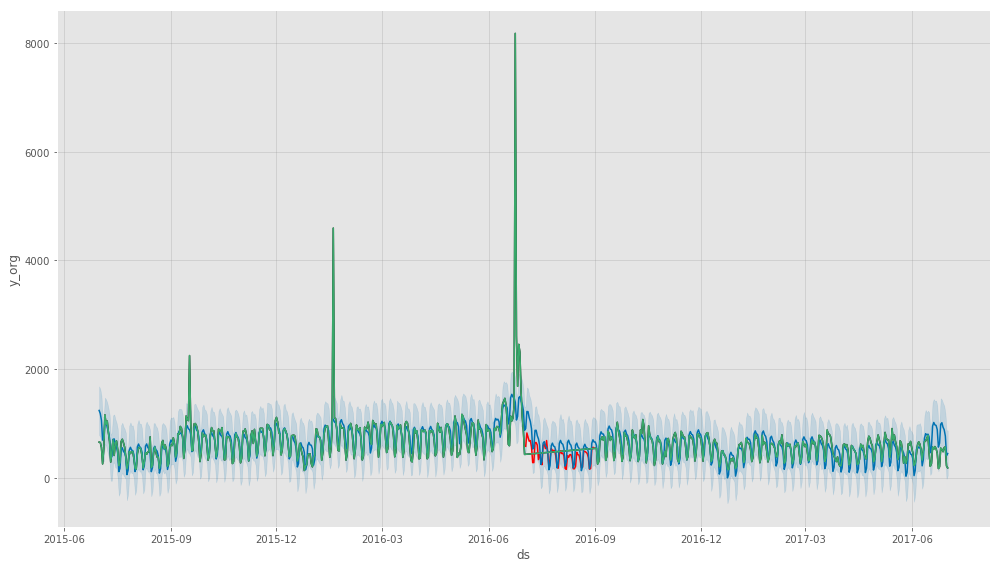

page_index                                                             137664
v7ty_train                                                             22.072
v7ty_val                                                              13.2438
v7t_train                                                             21.1773
v7t_val                                                                186.34
Page                        Gemeiner_Rhabarber_de.wikipedia.org_all-access...
median_pred_60                                                            677
median_pred_120                                                           963
prevYear_median_pred_60                                                  1330
prevYear_median_pred_120                                                  891
smape_60_to_0                                                         70.4007
smape_120_to_60                                                       33.0994
prevYear_smape_60_to_0                                          

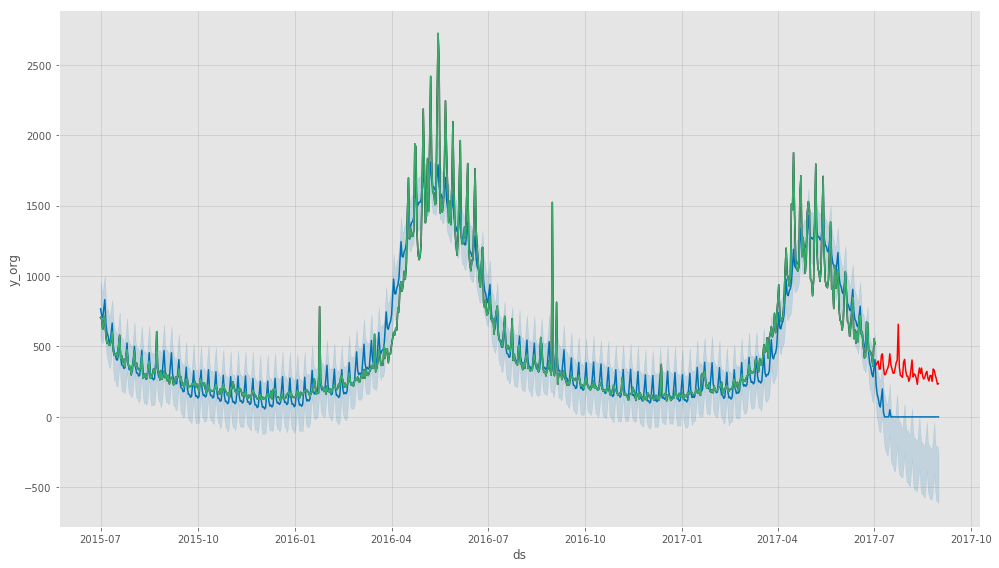

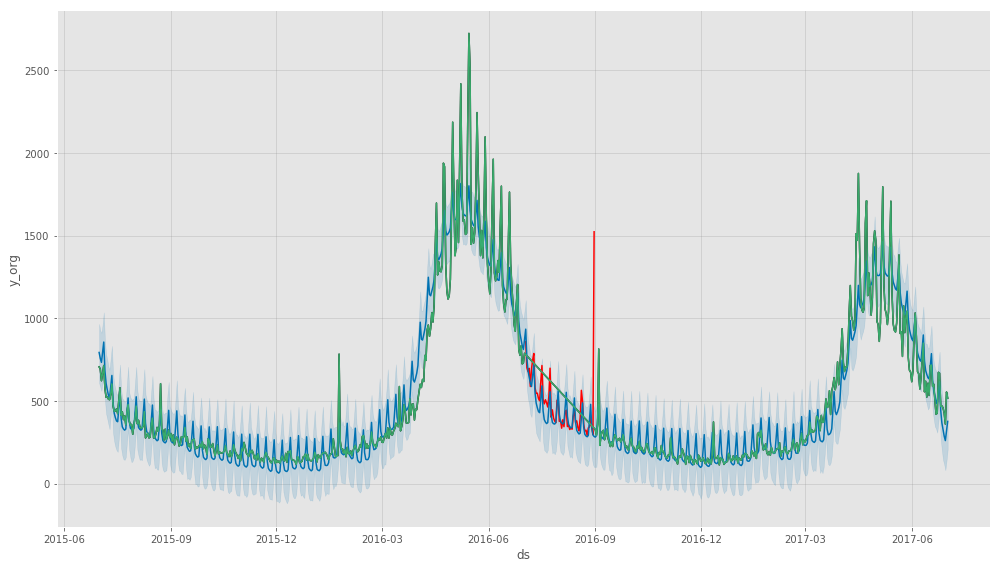

page_index                                                             12163
v7ty_train                                                           15.7424
v7ty_val                                                             25.8484
v7t_train                                                            20.7768
v7t_val                                                              140.198
Page                        Zara_Larsson_en.wikipedia.org_desktop_all-agents
median_pred_60                                                          1839
median_pred_120                                                         2770
prevYear_median_pred_60                                                 3898
prevYear_median_pred_120                                                3981
smape_60_to_0                                                        31.1736
smape_120_to_60                                                      38.8396
prevYear_smape_60_to_0                                               47.0051

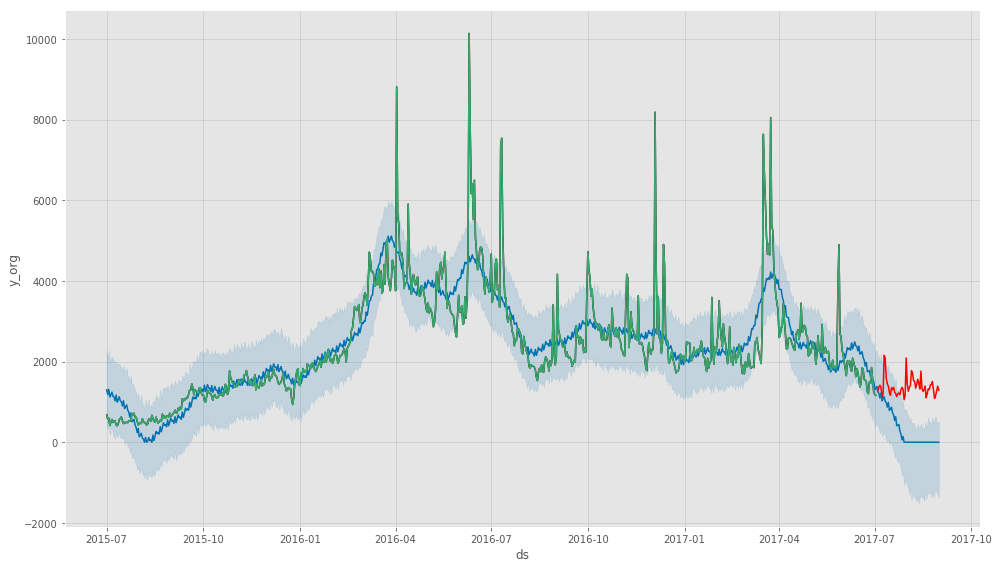

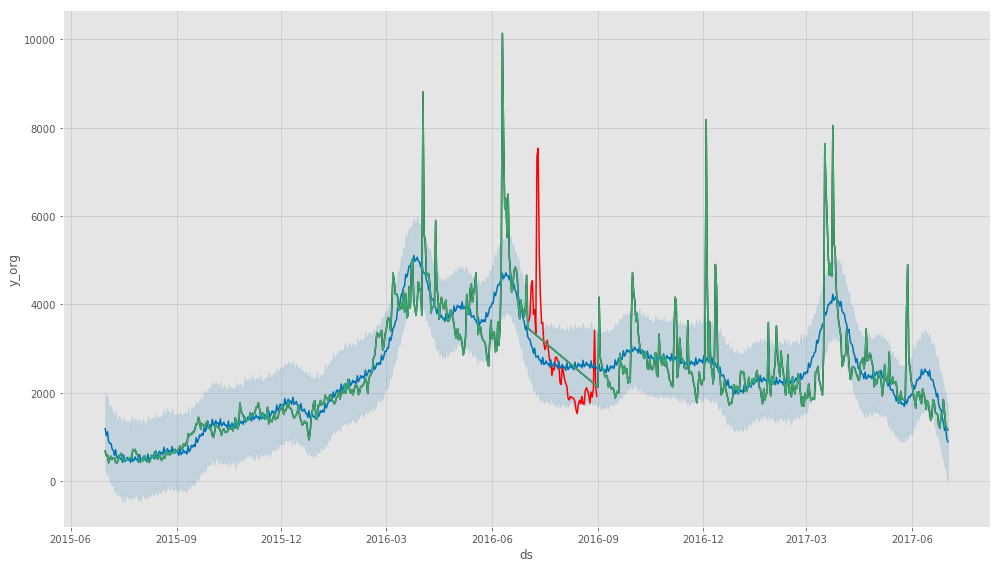

page_index                                                              13064
v7ty_train                                                            17.5842
v7ty_val                                                              32.0127
v7t_train                                                             17.1592
v7t_val                                                               141.679
Page                        Template:Iraqi_insurgency_detailed_map_en.wiki...
median_pred_60                                                           1636
median_pred_120                                                          1263
prevYear_median_pred_60                                                  3502
prevYear_median_pred_120                                                 2546
smape_60_to_0                                                          32.801
smape_120_to_60                                                       24.4634
prevYear_smape_60_to_0                                          

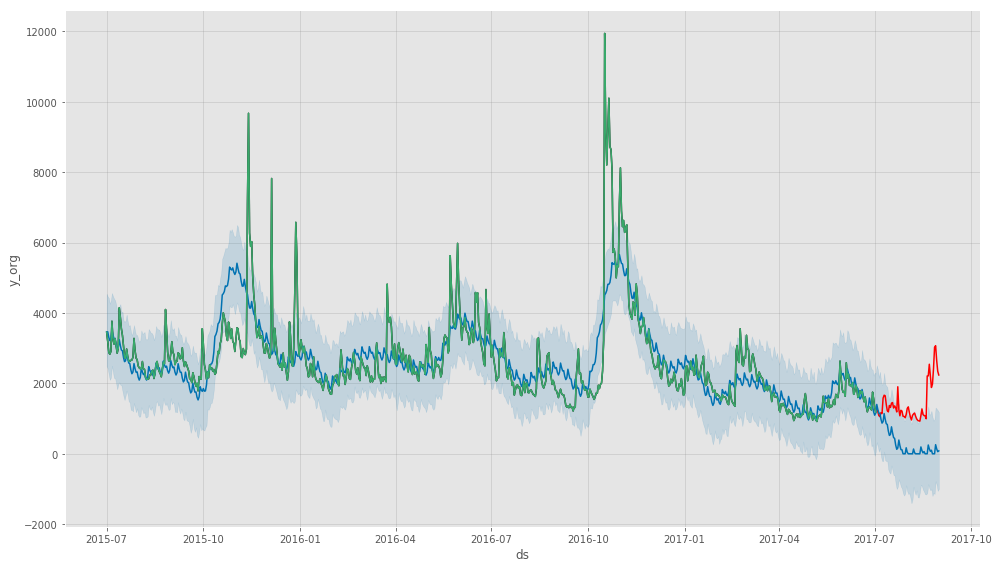

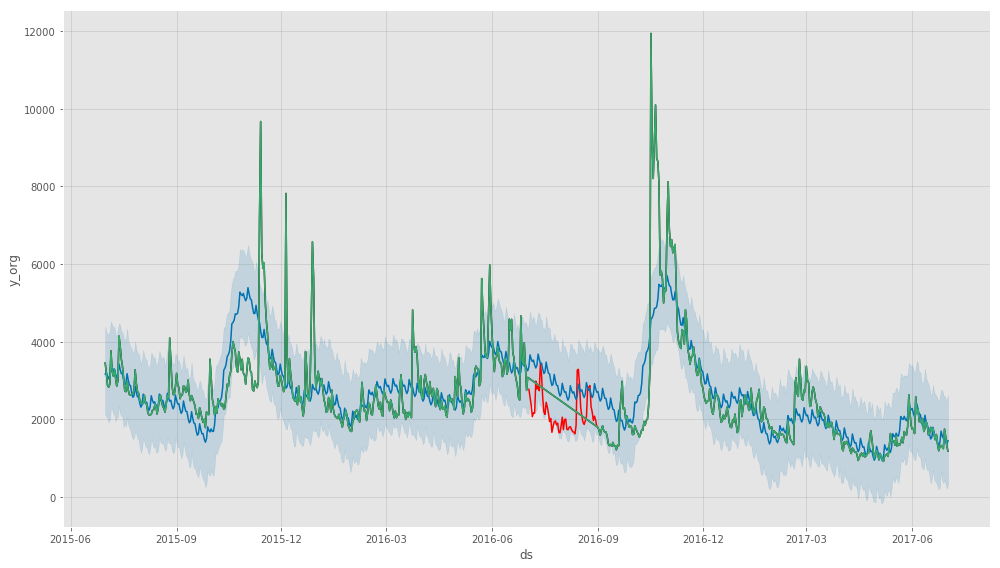

page_index                                                               6337
v7ty_train                                                            18.2773
v7ty_val                                                              38.9086
v7t_train                                                             18.7674
v7t_val                                                                157.86
Page                        Civilisation_maya_fr.wikipedia.org_desktop_all...
median_pred_60                                                            323
median_pred_120                                                           503
prevYear_median_pred_60                                                   482
prevYear_median_pred_120                                                  488
smape_60_to_0                                                          52.462
smape_120_to_60                                                       42.1913
prevYear_smape_60_to_0                                          

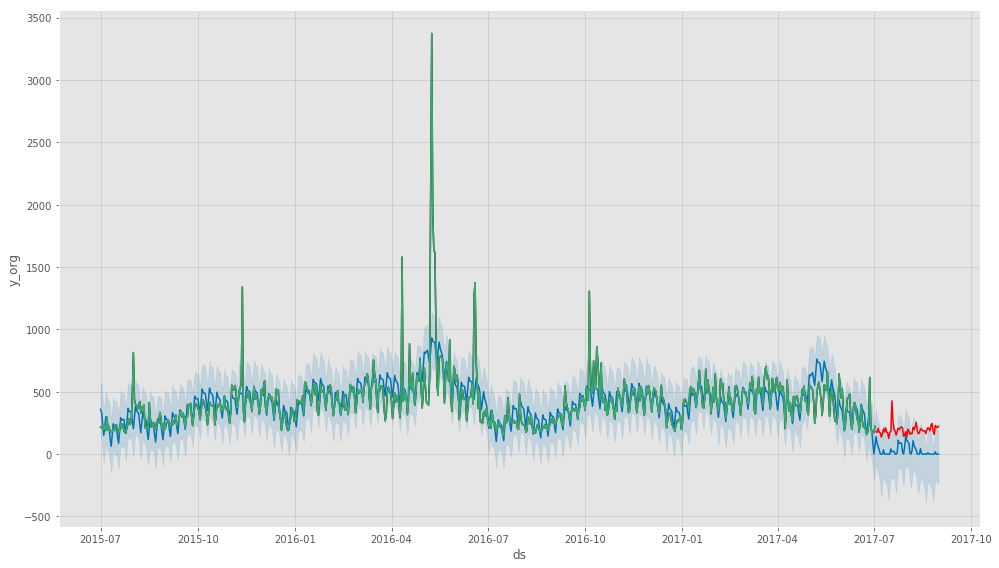

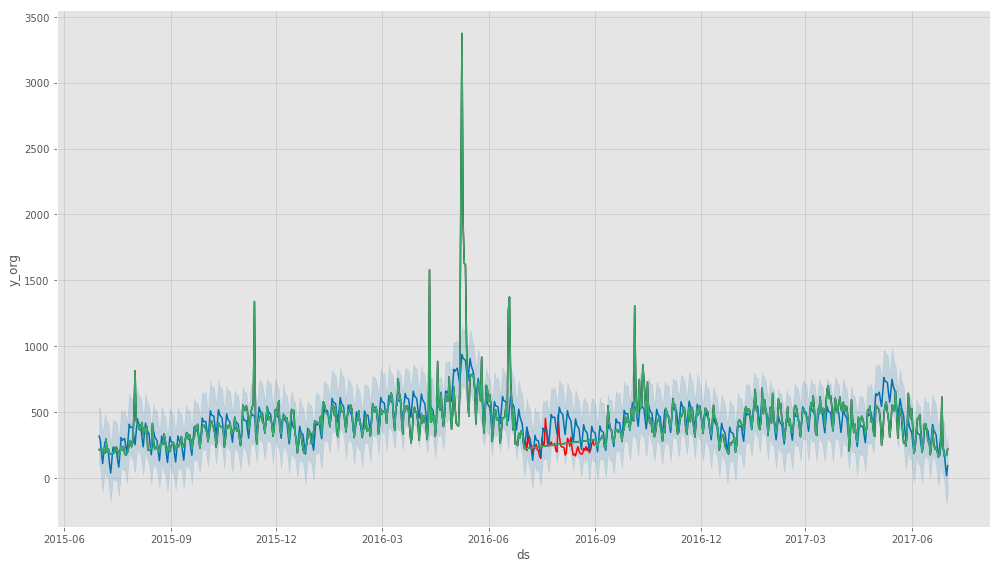

page_index                                                          5359
v7ty_train                                                       14.8124
v7ty_val                                                         23.0075
v7t_train                                                        15.4329
v7t_val                                                          134.406
Page                        LinkedIn_fr.wikipedia.org_desktop_all-agents
median_pred_60                                                       370
median_pred_120                                                      468
prevYear_median_pred_60                                              485
prevYear_median_pred_120                                             474
smape_60_to_0                                                    31.6467
smape_120_to_60                                                  35.4685
prevYear_smape_60_to_0                                           56.7543
prevYear_smape_120_to_60                           

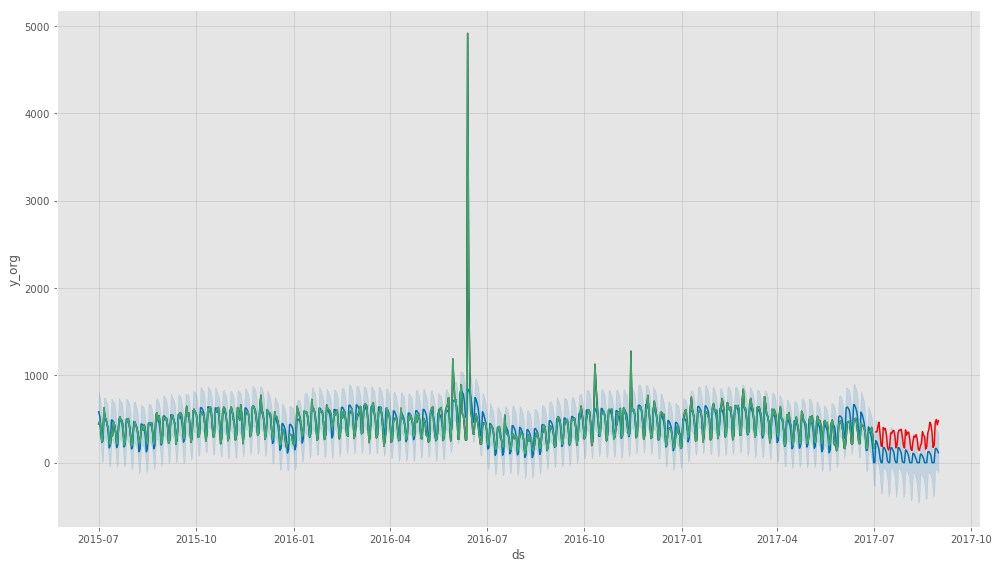

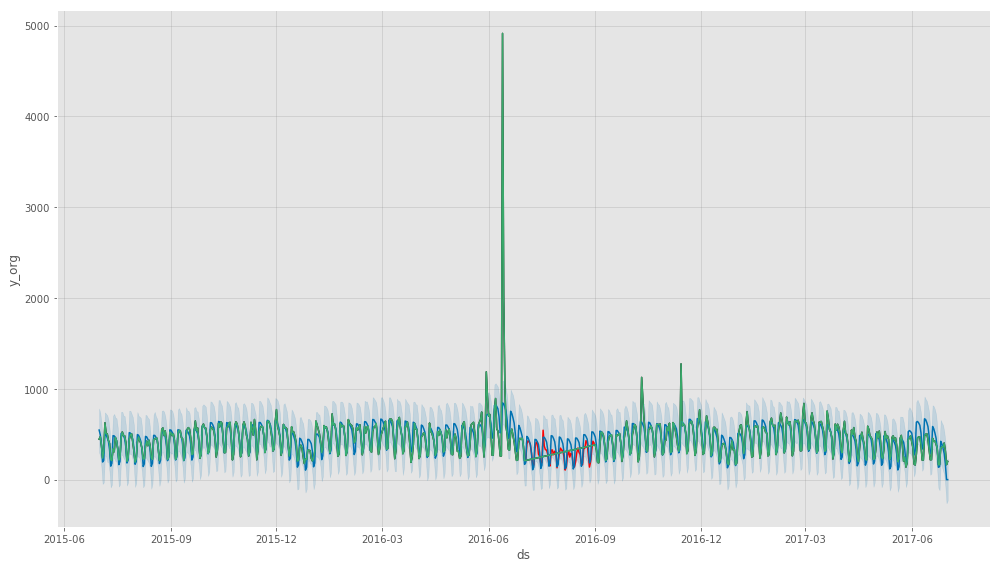

In [188]:
# worst
for row in df[filter_df].sort_values(
    by='test_gain', ascending=True).iloc[:10].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

page_index                                                     176
v7ty_train                                                       0
v7ty_val                                                       100
v7t_train                                                        0
v7t_val                                                          0
Page                        xss_zh.wikipedia.org_all-access_spider
median_pred_60                                                   0
median_pred_120                                                  1
prevYear_median_pred_60                                          0
prevYear_median_pred_120                                         0
smape_60_to_0                                                  200
smape_120_to_60                                                NaN
prevYear_smape_60_to_0                                           0
prevYear_smape_120_to_60                                       NaN
nans_start_to_120                                             

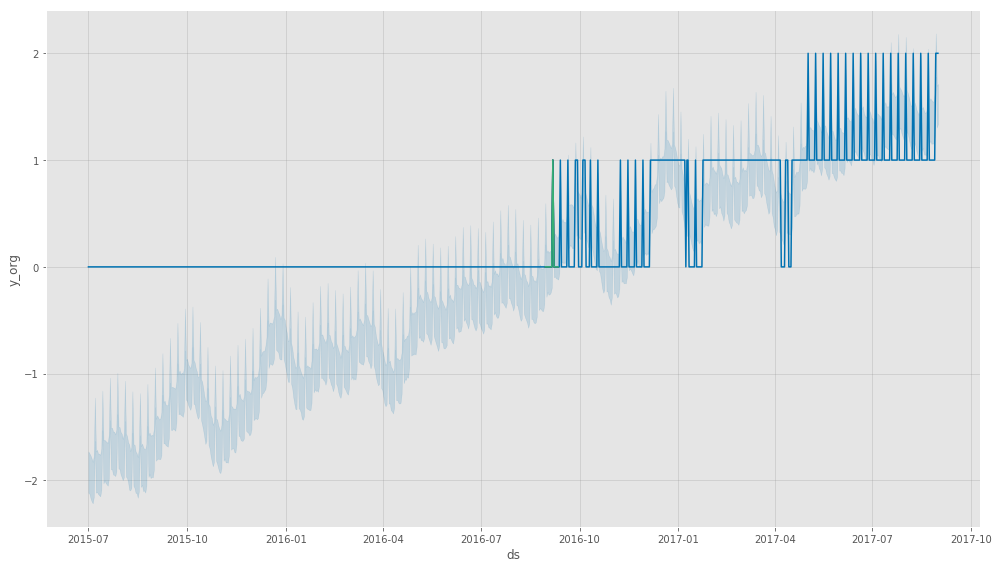

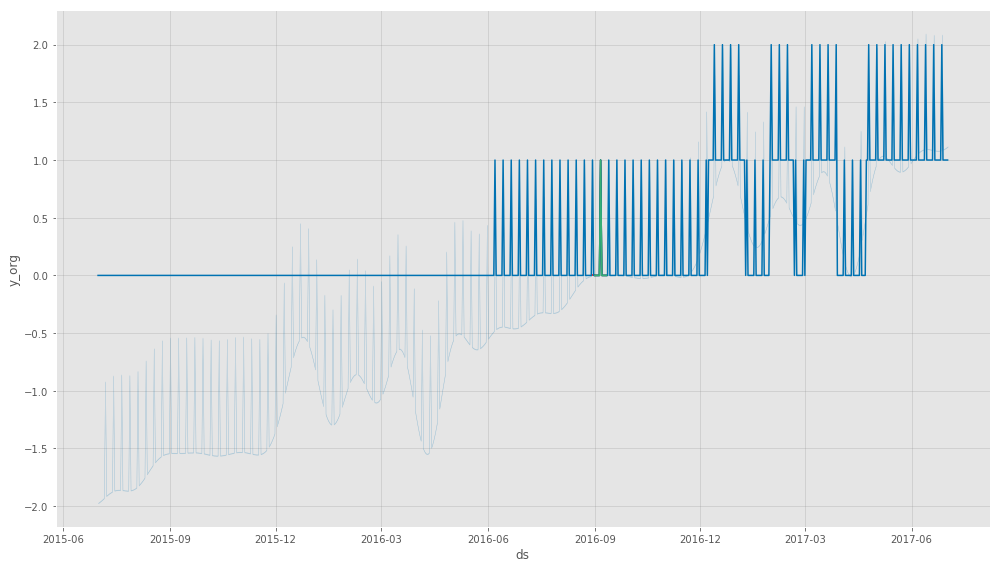

page_index                                                              15821
v7ty_train                                                            18.9055
v7ty_val                                                                    0
v7t_train                                                             18.6275
v7t_val                                                               85.4545
Page                        File:Froissart_-_Méliador,_tome_1.tif_commons....
median_pred_60                                                              0
median_pred_120                                                             0
prevYear_median_pred_60                                                     0
prevYear_median_pred_120                                                    0
smape_60_to_0                                                         181.818
smape_120_to_60                                                             0
prevYear_smape_60_to_0                                          

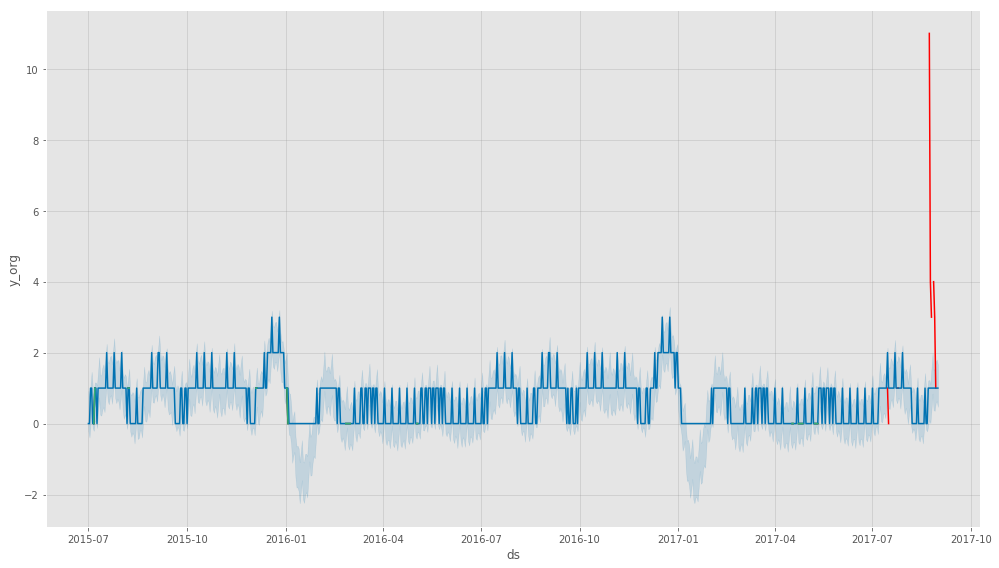

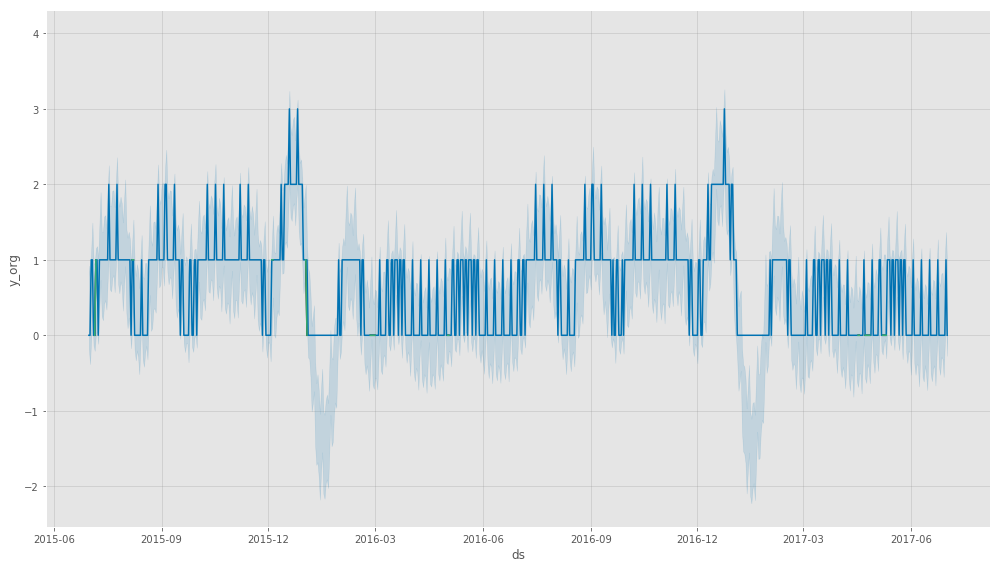

page_index                                                      56156
v7ty_train                                                    24.9261
v7ty_val                                                      19.2038
v7t_train                                                     27.7878
v7t_val                                                       23.9218
Page                        アブ_ja.wikipedia.org_mobile-web_all-agents
median_pred_60                                                    415
median_pred_120                                                   137
prevYear_median_pred_60                                           368
prevYear_median_pred_120                                          157
smape_60_to_0                                                  113.57
smape_120_to_60                                               95.7257
prevYear_smape_60_to_0                                        109.694
prevYear_smape_120_to_60                                      78.0887
nans_start_to_120   

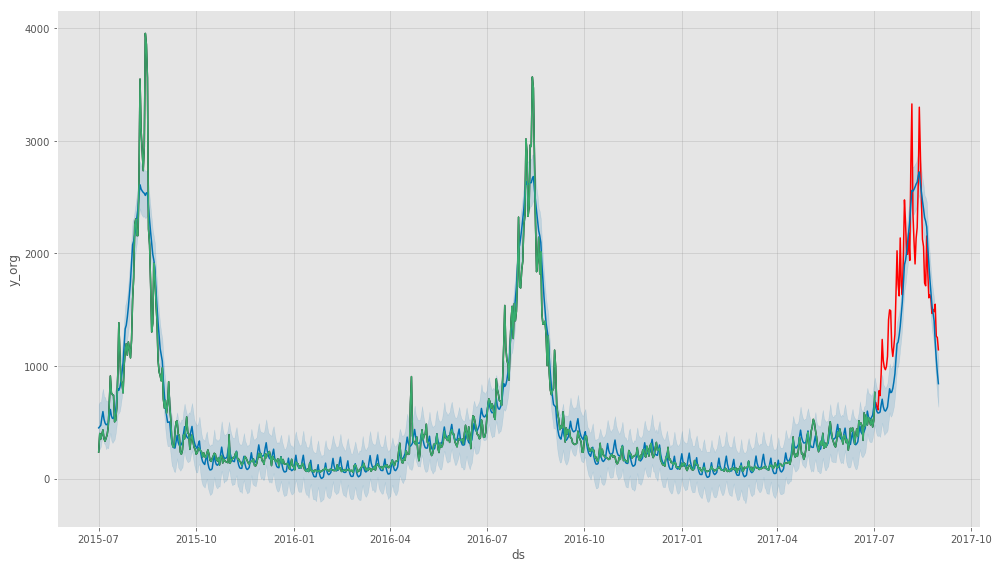

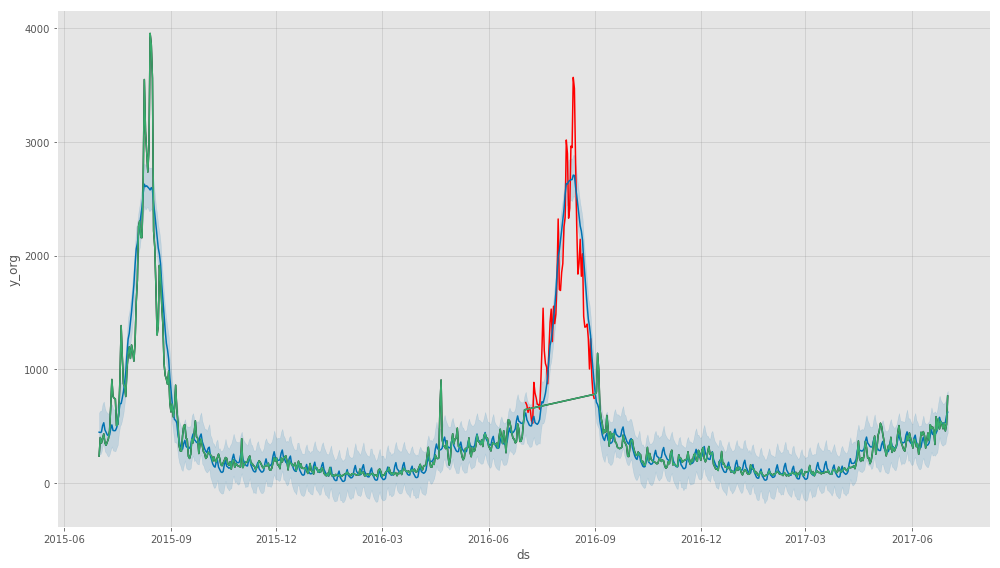

page_index                                                     120490
v7ty_train                                                    18.9145
v7ty_val                                                      18.5172
v7t_train                                                     20.0995
v7t_val                                                       22.9089
Page                        アブ_ja.wikipedia.org_all-access_all-agents
median_pred_60                                                    557
median_pred_120                                                   206
prevYear_median_pred_60                                           570
prevYear_median_pred_120                                          263
smape_60_to_0                                                 111.192
smape_120_to_60                                               90.7472
prevYear_smape_60_to_0                                        99.2742
prevYear_smape_120_to_60                                       68.051
nans_start_to_120   

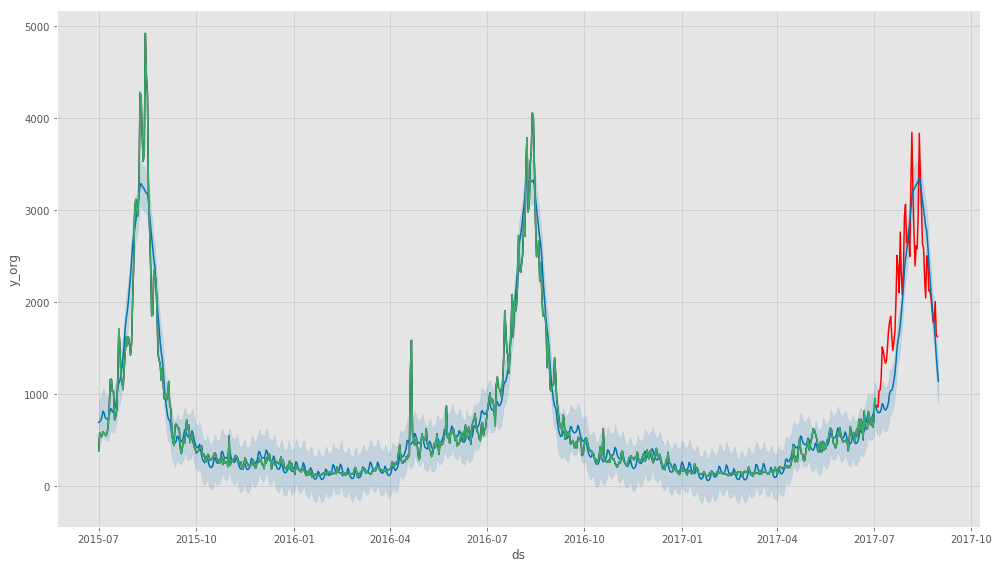

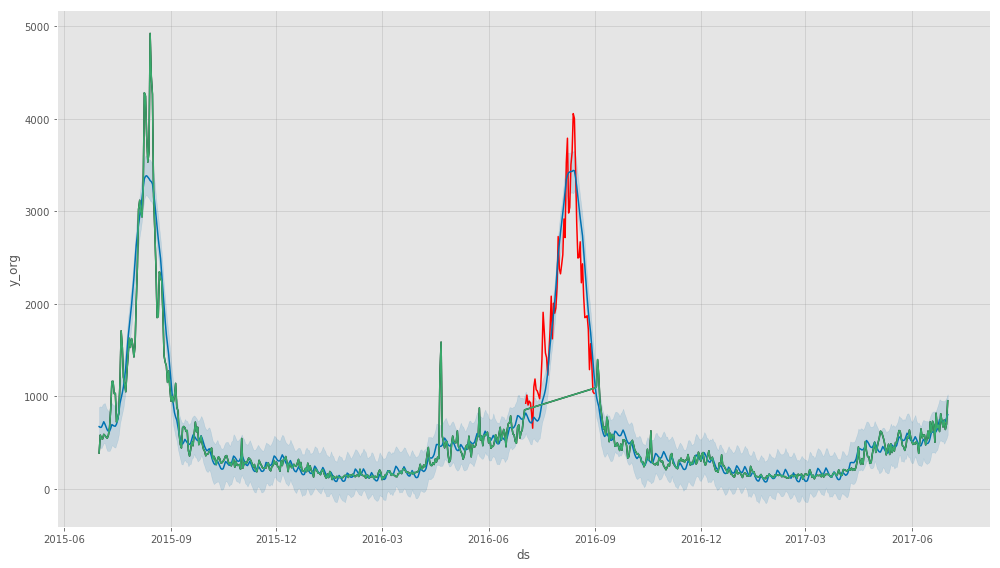

page_index                                                              15833
v7ty_train                                                            12.5786
v7ty_val                                                                    0
v7t_train                                                             12.3457
v7t_val                                                               89.6296
Page                        File:Villemain_-_Souvenirs_contemporains_d’his...
median_pred_60                                                              0
median_pred_120                                                             0
prevYear_median_pred_60                                                     0
prevYear_median_pred_120                                                    0
smape_60_to_0                                                         177.778
smape_120_to_60                                                             0
prevYear_smape_60_to_0                                          

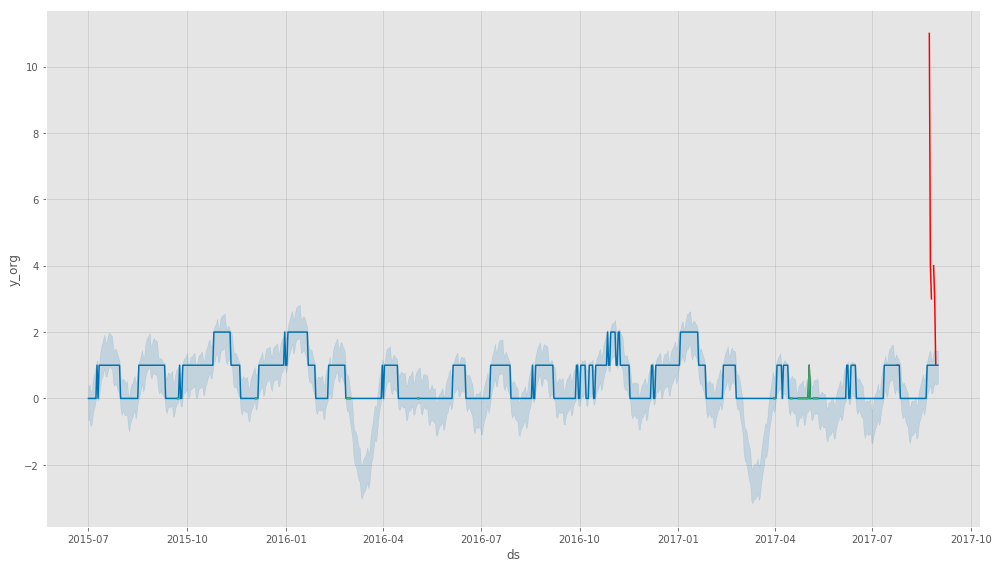

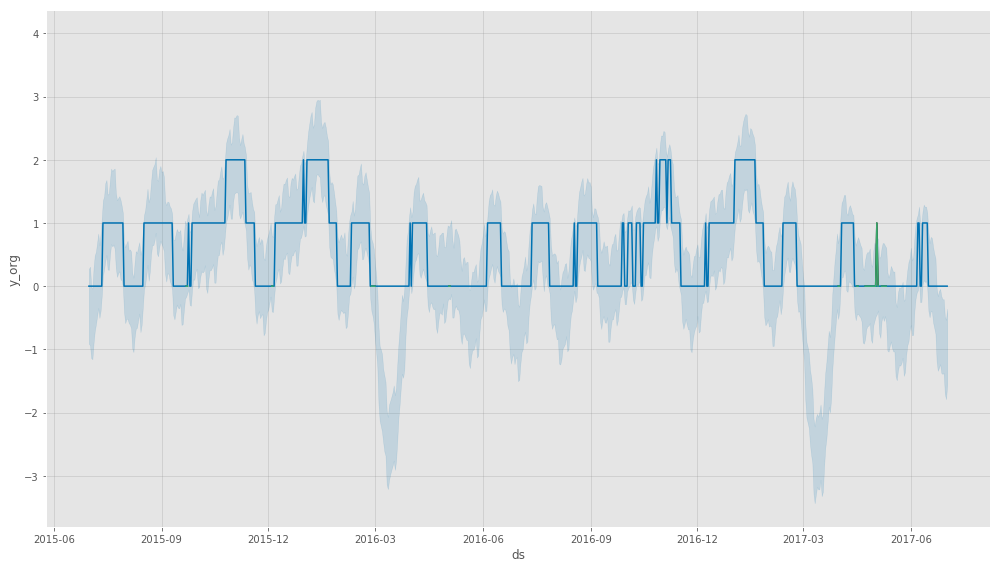

page_index                                                              96830
v7ty_train                                                            29.8627
v7ty_val                                                              31.9634
v7t_train                                                             28.9507
v7t_val                                                               35.7056
Page                        Ejército_Zapatista_de_Liberación_Nacional_es.w...
median_pred_60                                                           1355
median_pred_120                                                           451
prevYear_median_pred_60                                                  1424
prevYear_median_pred_120                                                  452
smape_60_to_0                                                         121.958
smape_120_to_60                                                       82.9416
prevYear_smape_60_to_0                                          

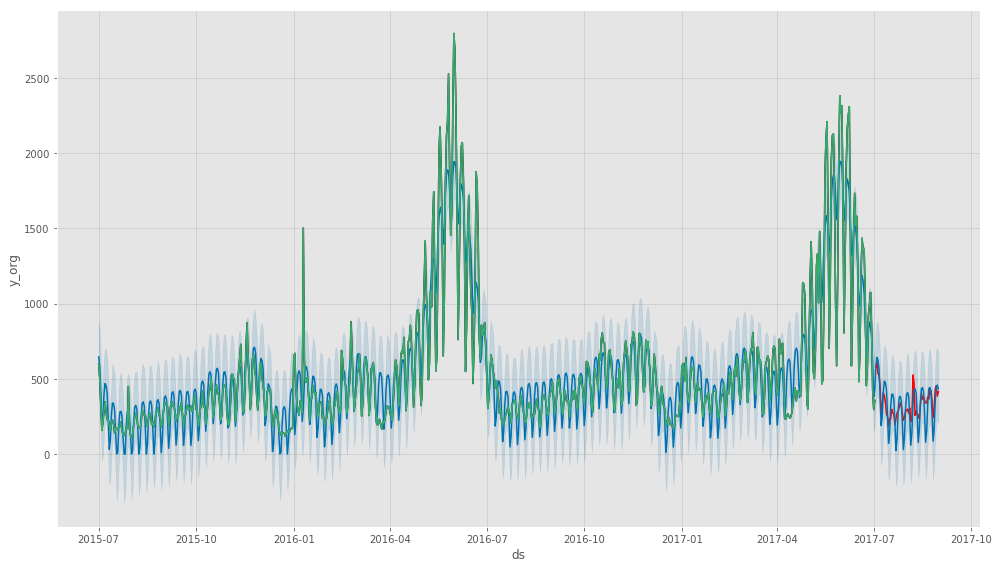

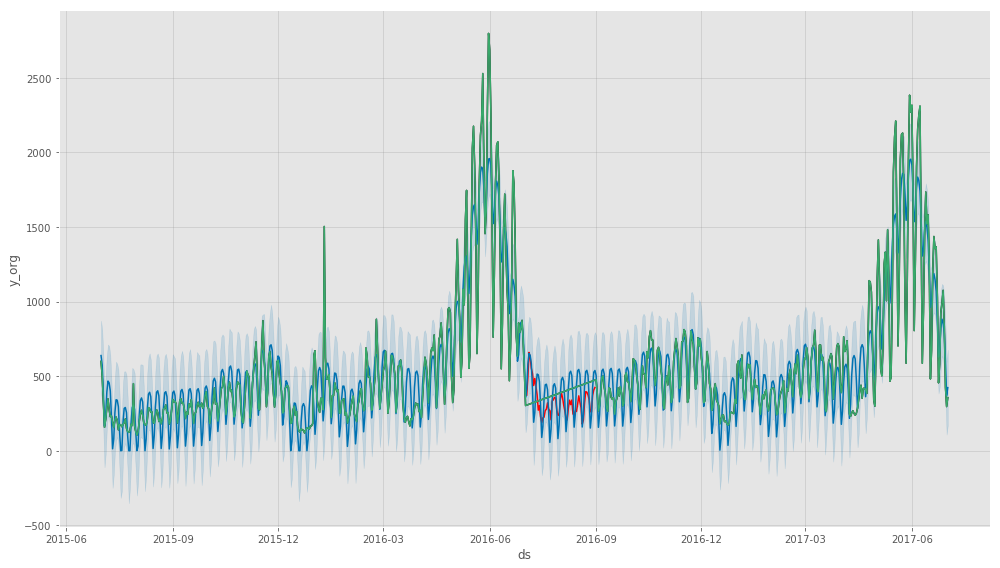

page_index                                                           57663
v7ty_train                                                         19.8793
v7ty_val                                                           56.2012
v7t_train                                                          23.9207
v7t_val                                                            16.8403
Page                        青春18きっぷ_ja.wikipedia.org_mobile-web_all-agents
median_pred_60                                                         535
median_pred_120                                                        750
prevYear_median_pred_60                                                441
prevYear_median_pred_120                                               725
smape_60_to_0                                                      102.156
smape_120_to_60                                                    39.2037
prevYear_smape_60_to_0                                             70.2151
prevYear_smape_120_to_60 

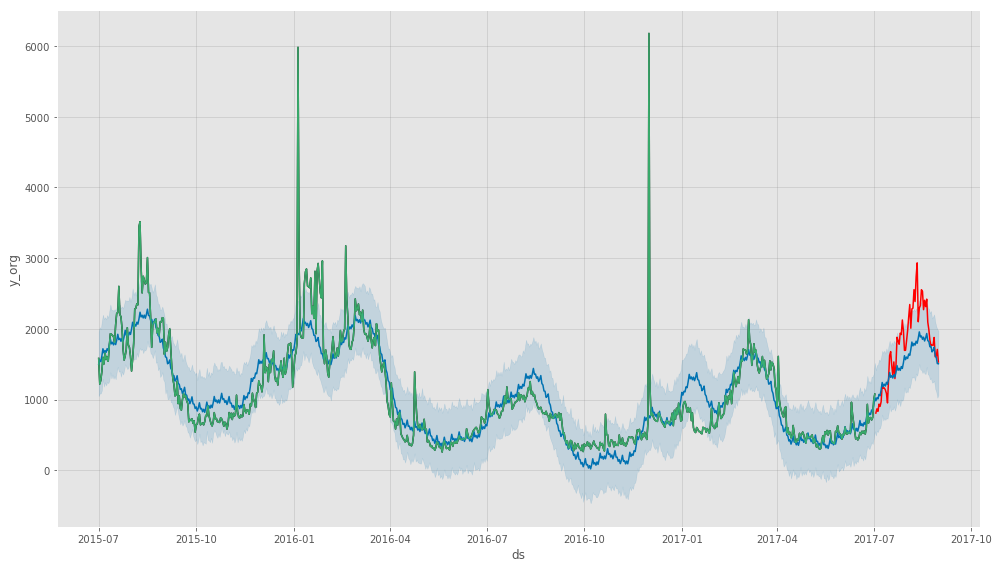

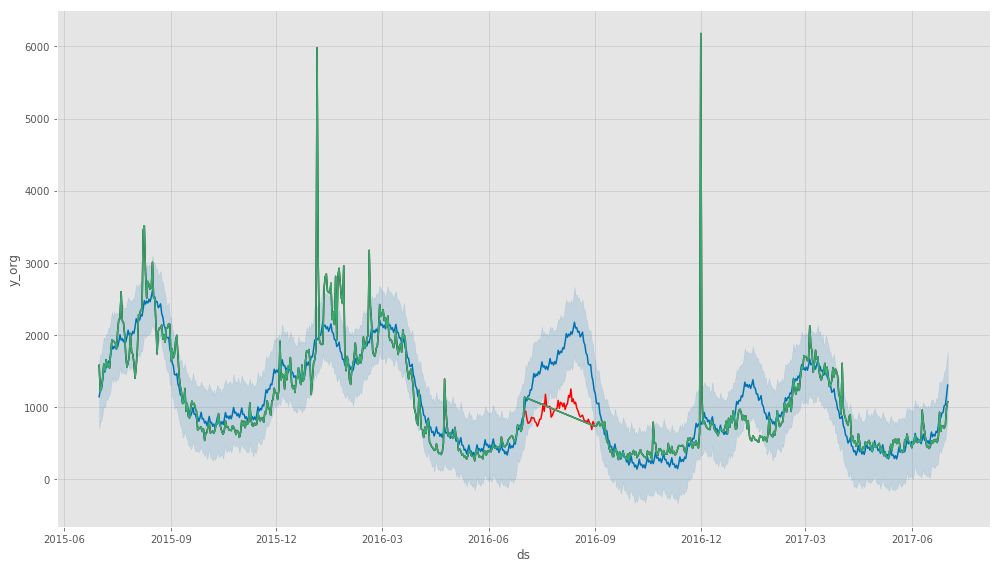

page_index                                                              94258
v7ty_train                                                            42.0097
v7ty_val                                                              59.3636
v7t_train                                                             41.2788
v7t_val                                                               29.8288
Page                        Desastre_natural_es.wikipedia.org_mobile-web_a...
median_pred_60                                                           3020
median_pred_120                                                          1219
prevYear_median_pred_60                                                  2537
prevYear_median_pred_120                                                  835
smape_60_to_0                                                         112.402
smape_120_to_60                                                       70.8142
prevYear_smape_60_to_0                                          

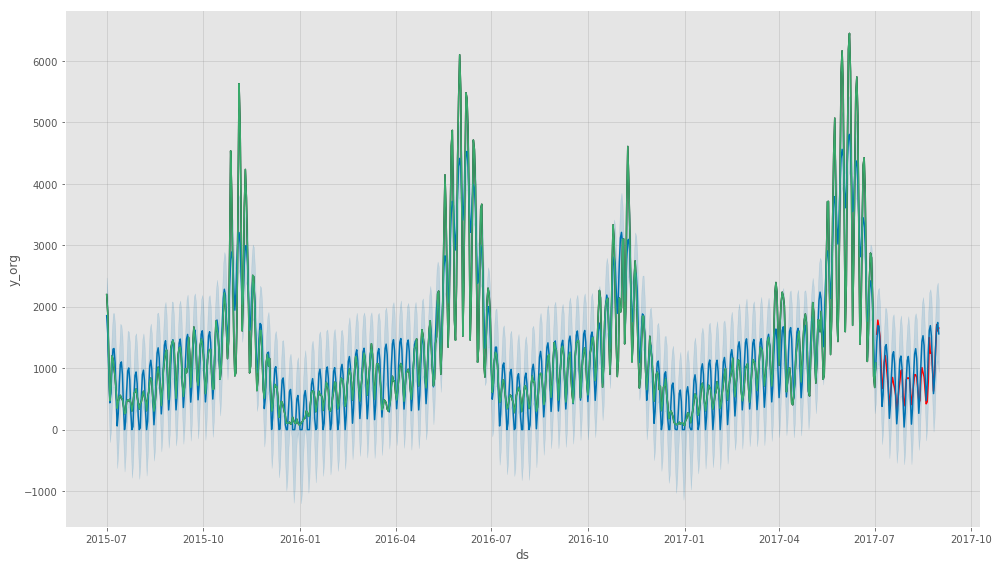

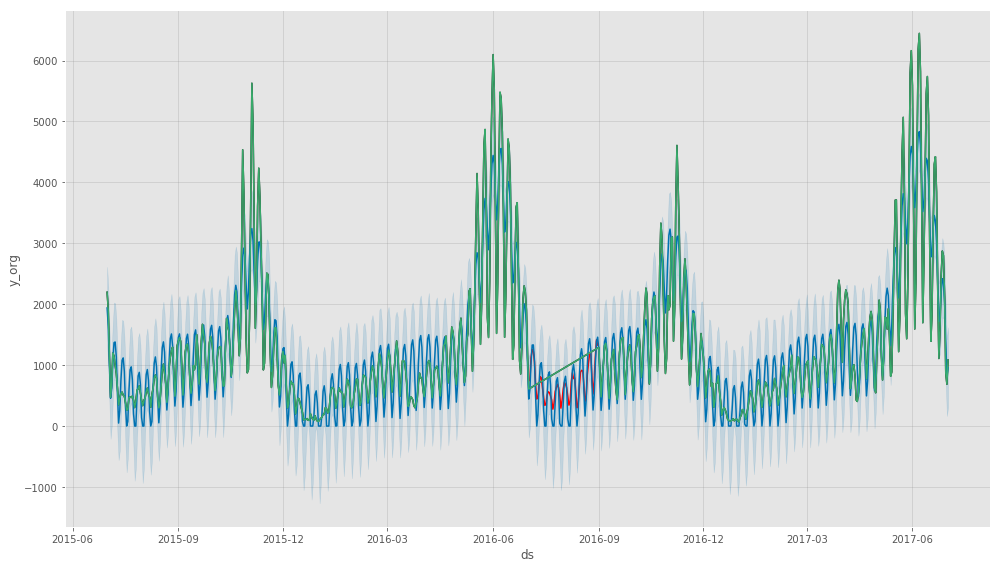

page_index                                                          120699
v7ty_train                                                         18.7532
v7ty_val                                                            51.057
v7t_train                                                          21.2397
v7t_val                                                             13.486
Page                        青春18きっぷ_ja.wikipedia.org_all-access_all-agents
median_pred_60                                                         788
median_pred_120                                                       1051
prevYear_median_pred_60                                                726
prevYear_median_pred_120                                              1118
smape_60_to_0                                                      92.1947
smape_120_to_60                                                    34.9193
prevYear_smape_60_to_0                                             57.4885
prevYear_smape_120_to_60 

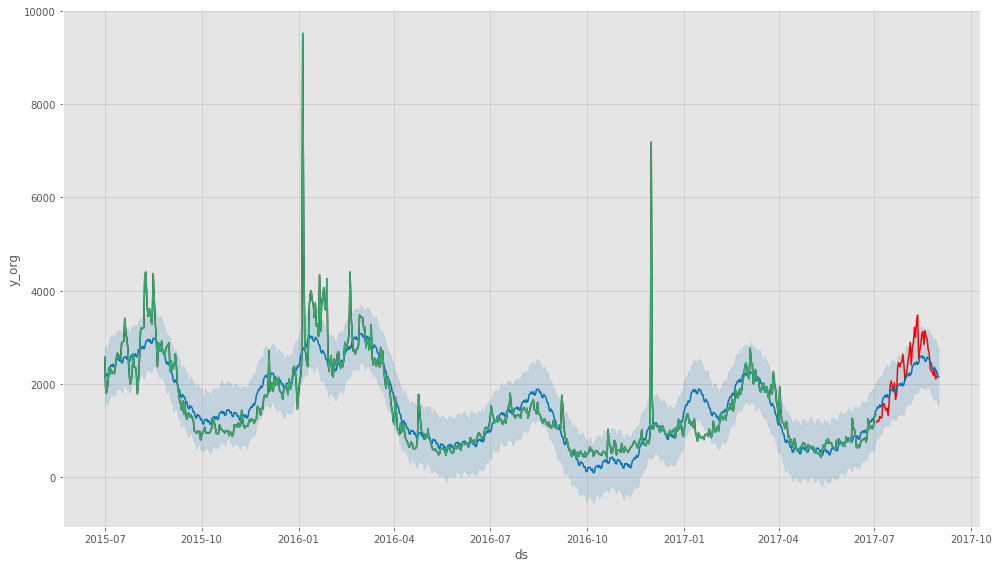

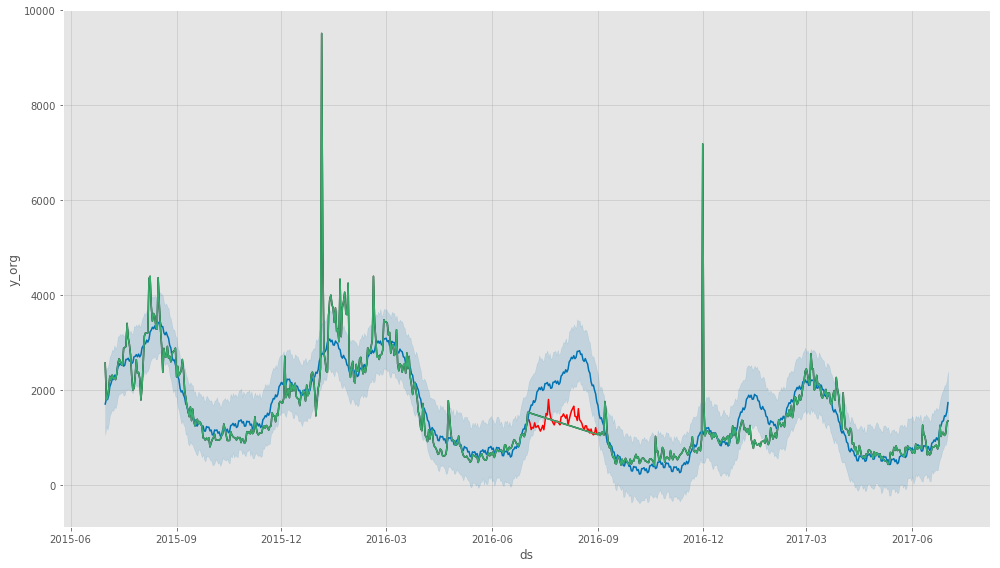

page_index                                                       106843
v7ty_train                                                      18.7886
v7ty_val                                                        30.0012
v7t_train                                                       20.3071
v7t_val                                                         19.5783
Page                        黑色魔術_zh.wikipedia.org_mobile-web_all-agents
median_pred_60                                                       98
median_pred_120                                                     106
prevYear_median_pred_60                                              84
prevYear_median_pred_120                                             97
smape_60_to_0                                                   97.9958
smape_120_to_60                                                 27.8013
prevYear_smape_60_to_0                                          98.4241
prevYear_smape_120_to_60                                        

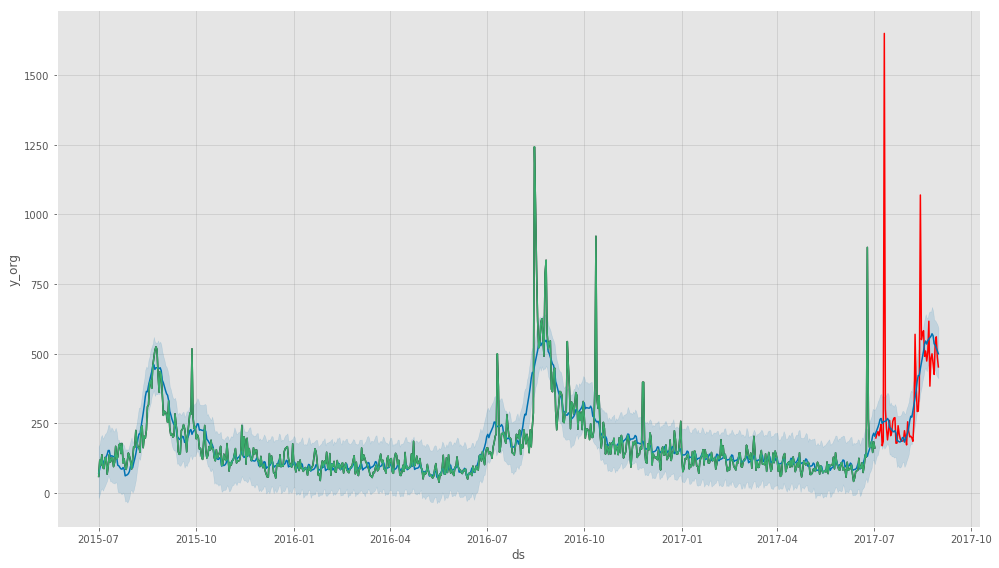

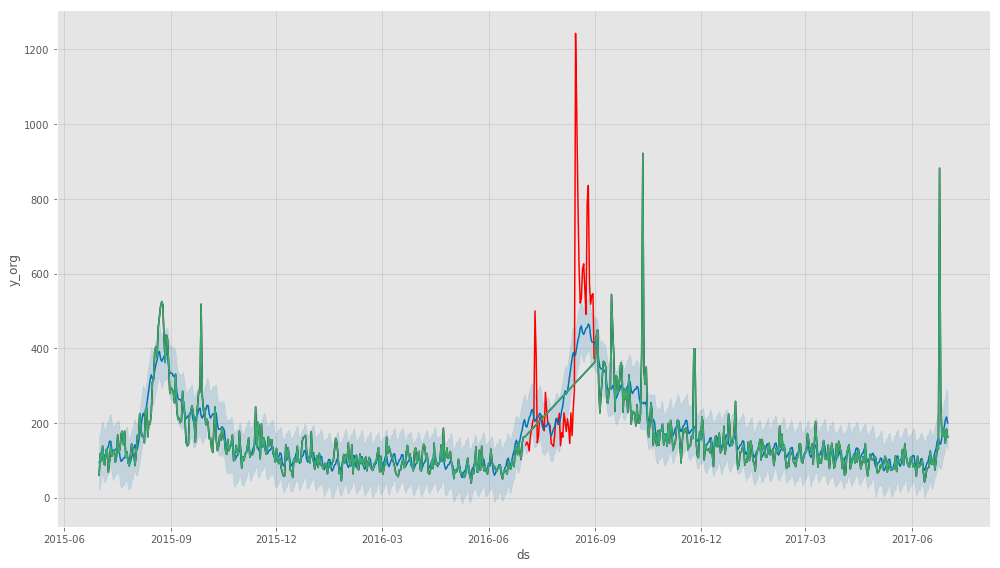

In [189]:
# best
for row in df[filter_df].sort_values(
    by='test_gain', ascending=False).iloc[:10].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

# Saving Results 

In [186]:
# save the pages and val scores
df[filter_df][['page_index','v7t_val']].reset_index().drop('index', axis=1).to_feather(
    #'../data/prophet/results/proph_v7_vals.f')

SyntaxError: unexpected EOF while parsing (<ipython-input-186-199ed2d99082>, line 3)

In [187]:
# save the pages and val scores
# need to grab yhat here I think
yhat[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather(
    #'../data/prophet/results/proph_v7_preds.f')

SyntaxError: unexpected EOF while parsing (<ipython-input-187-24f78de871a1>, line 4)